# Attempt to split available, suitable QCA datasets into data for benchmarking

Our plan here is to utilize the training molecules, along with information on chemical similarity and parameter coverage, to split the available benchmarking data into:
1. Primary sets, covering similar chemistry as training data:
   a. Test set, to be revisited potentially several times while testing
   b. Benchmark set, to be used only in assessing final FF
2. "Stretch" sets, covering more chemical diversity
   a. Test set, to be revisited potentially several times during testing
   b. Benchmark set, to be used only in assessing final FF
   
Partitioning into test and benchmark sets will be done randomly.

In this notebook we are mainly concerned about the filtering procedure to divide between primary and stretch sets.

## Big picture outline
1. Obtain training set data and potential test set data
2. Obtain parameter usage statistics for training set data (TO BE DONE) 
3. Compute chemical graph similarity matrix of all molecules
4. Cluster all molecules based on graph similarity using `DBSCAN`
5. Pick potential test set molecules as those which are in clusters with at least one training set molecule. 
6. Save molecules which are NOT in clusters with training set molecules as potential "stretch test set" molecules
7. Check parameter usage of all potential primary test set molecules; any which use especially unusual parameters get moved from test set to stretch test set (TO BE DONE)
8. Take candidate test set/stretch test set molecules and randomly partition them into test and benchmark sets (primary and stretch)



# Begin

## Begin by grabbing datasets we fit to from Yudong Qiu's releases

Specifically, we're interested in seeing which molecules are present in those sets.

Slack discussion here: https://openforcefieldgroup.slack.com/archives/C8P8MLALD/p1568325818091700. Script for extracting molecules from a release: https://github.com/lpwgroup/forcebalance-qcarchive/blob/master/analysis_scripts/find_unique_molecule_smiles.py .  Set from most recent release: https://openforcefieldgroup.slack.com/files/U8ZH3MTL2/FNBUUCADB/target_smiles.txt

In [104]:
# Load molecules used in release-1 fitting
file = open('target_smiles.txt', 'r')
text = file.readlines()
release_smi = [ line.split()[0] for line in text]


## Compute parameter usage statistics for training set molecules

Can draw on `openforcefield/utilities/deprecated/convert_frosst/parameter_usage.ipynb`
Also drawing on `openforcefield/examples/.../inspect_assigned_parameters.ipynb`

**This will take a few minutes or more to run.**

In [53]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField

# Initialize storage
parameters_by_ID = dict()

# Let's label using our RC force field
forcefield = ForceField('openff_unconstrained-1.0.0-RC1.offxml')

# Loop over smiles
for smi in release_smi:

    # Create a simple molecule from SMILES and turn it into a topology.
    molecule = Molecule.from_smiles(smi)
    topology = Topology.from_molecules([molecule])

    # Run the molecule labeling
    molecule_force_list = forcefield.label_molecules(topology)

    #print(smi)
    # Print out a formatted description of the parameters applied to this molecule
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        for force_tag, force_dict in mol_forces.items():
            for (atom_indices, parameter) in force_dict.items():
                pid = parameter.id
                if not pid in parameters_by_ID:
                    parameters_by_ID[pid] = set()
                parameters_by_ID[pid].add(smi)

#print(parameters_by_ID)


{'b83': {'Cc1ccccc1n2cccn2', 'CC(=O)Nc1nccn1C', 'CN(C)C(=O)Cc1ccccc1', 'c1ccc(cc1)[C@@H]2CCCO2', 'CNC(=O)NC1COC1', 'c1cc(c(nc1)C2CCCC2)F', 'Cc1cccc(c1NC)C', 'CCS(=O)(=O)c1ccccc1', 'Cn1c(cccc1=O)c2ccccc2OC', 'CNC(=O)c1cccc(=O)n1C', 'C1=N[C@@H](C(=N1)C(=O)N)[N+]#N', 'c1ccc(cc1)Cc2[nH]ccn2', 'CNC(=O)c1cccc(=O)[nH]1', 'CC(=O)c1ccc(cc1)S(=C)(=C)C', 'CC(=O)NCc1[nH]ccn1', 'Cc1cccnc1OC', 'c1ccc2c(c1)C(=NCC(=O)N2)c3cccc(=O)[nH]3', 'CNC(=O)COC', 'c1ccnc(c1)Cc2[nH]ccn2', 'CN(C)S(=O)(=O)c1ccccn1', 'c1cc(c(=O)[nH]c1)C2C=CCC=C2', 'CC(=C)C1(CC1)CO[NH3+]', 'CC(=O)N(C)c1ncccn1', 'CNC(=O)Nc1ccccn1', 'c1ccc(c(c1)N2CCCC2)F', 'CC[C@H]1C[C@@]1(c2ccc(nn2)OC)N', 'CSC(=S)NN', 'c1ccc(cc1)Cc2ncco2', 'c1ccc(cc1)N2CCCC2', 'CSC(=S)[N-]N', 'c1ccnc(c1)Cn2ccnc2', 'CNc1ccccc1', 'CN(C)c1ccccc1', 'CC(C)n1ccccc1=O', 'C(CBr)c1[nH]nnn1', 'CC1=NCC(=O)Nc2c1cccc2', 'c1ccc(cc1)C2=NCC(=O)Nc3c2cccc3', 'CN(C)C(=O)c1c(cc[nH]1)N', 'C[S@](=O)c1ccccc1Cl', 'CC1([C@H]2[C@H]1CCC2)O', 'CN(c1ccccn1)C(=O)N', 'c1cnc([nH]1)C[C@H]2CCCNC2=O', '

In [60]:
def make_param_histogram(param_id_counts, param_ids, letter, title):
    # Graph occurrences of bond parameters
    parm_ids = [ pid for pid in param_ids if pid[0]==letter]
    parm_ids.sort()
    counts_parms = [param_id_counts[parm_id] for parm_id in parm_ids]
    split = int(len(parm_ids)/2)
    
    indices = np.arange(len(parm_ids))
    fix, ax = plt.subplots(2,1,figsize=(16,5))
    ax[0].set_yscale('log', nonposy='clip')
    ax[1].set_yscale('log', nonposy='clip')
    
    rects2 = ax[0].bar(indices[0:split], counts_parms[0:split] )
    ax[0].set_ylabel('Count')
    ax[0].set_xticks( indices[0:split])
    ax[0].set_xticklabels( parm_ids[0:split], rotation=-60, ha='left')
    ax[0].set_xlim(indices[0], indices[split])
    plt.yscale('log',nonposy='clip')
    rects2 = ax[1].bar(indices[split:], counts_parms[split:])
    ax[1].set_ylabel('Count')
    ax[1].set_xticks( indices[split:])
    ax[1].set_xticklabels( parm_ids[split:], rotation=-60, ha='left')
    ax[1].set_xlim(indices[split], indices[-1]+1)
    
    ax[0].set_title(title)
    plt.show()

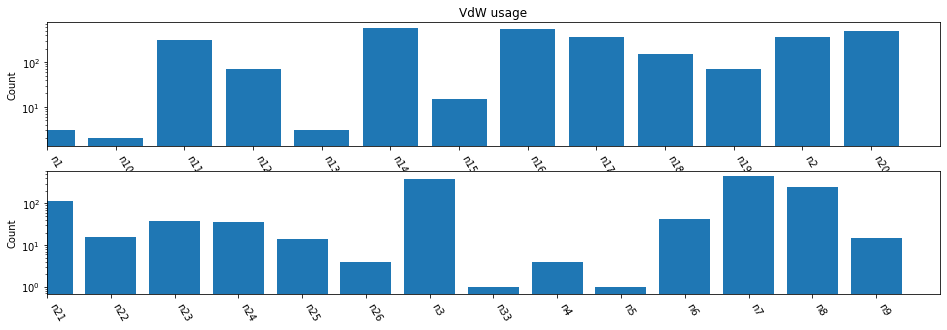

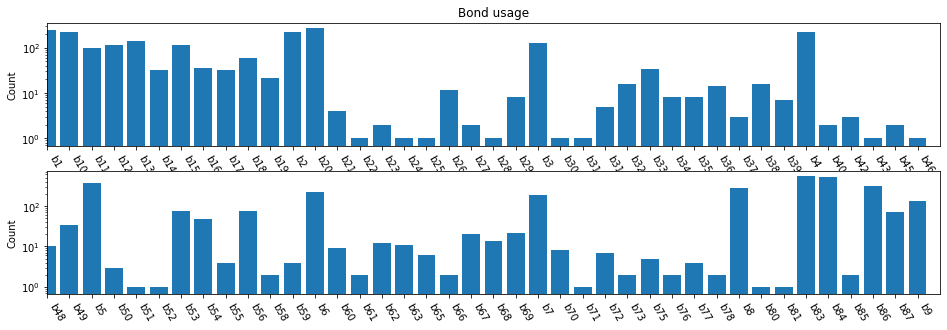

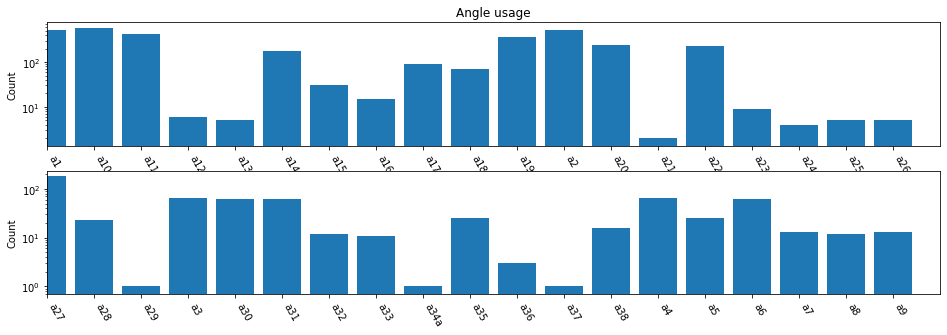

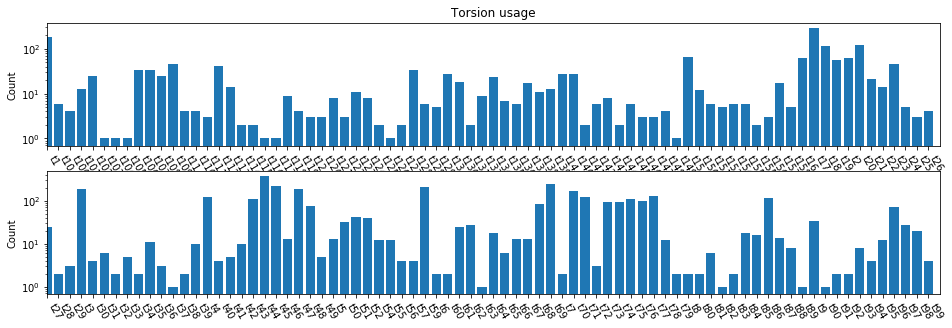

In [61]:
# Graph parameter usage
param_id_counts = dict()

for pid in parameters_by_ID:
    param_id_counts[pid] = len(parameters_by_ID[pid])

param_ids = param_id_counts.keys()

# Create Histogram for each type of parameter
# VdW
make_param_histogram(param_id_counts, param_ids, 'n', "VdW usage")
# Bonds
make_param_histogram(param_id_counts, param_ids, 'b', "Bond usage")
# Angles
make_param_histogram(param_id_counts, param_ids, 'a', "Angle usage")
# Torsions
make_param_histogram(param_id_counts, param_ids, 't', "Torsion usage")

In [82]:
# Build set of parameters which occur in less than N molecules
N = 3

rare_params = []
for pid in parameters_by_ID:
    if param_id_counts[pid] < N:
        rare_params.append(pid)
print(rare_params)
print("%s rare parameters out of %s in total" % (len(rare_params), len(param_id_counts)))

['b27', 'b85', 'b23', 'n10', 'b24', 't83', 'b58', 't114', 'b78', 'b25', 't38', 't34', 't28', 'b28', 't91', 't92', 'b40', 't117', 't105', 't126', 'b46', 't116', 'b66', 't144', 't7', 'b52', 'a34a', 't141', 't63', 't90', 'a37', 't131', 't60', 'a21', 't80', 't79', 't89', 'n5', 'b22', 'a29', 't103', 't104', 'b73', 't125', 'b43', 'b30', 'b31', 't149', 't127', 'b45', 'b71', 't37', 'b61', 't155b', 'b81', 't6', 't8', 'n33', 't82', 'b76', 't32', 'b80', 't115', 'b51']
64 rare parameters out of 305 in total


## Get available test set molecules

Note that these molecules have protonation states/tautomers enumerated so we probably have excessive representation of some molecules. Will likely want to filter to NOT have large numbers of molecules which differ only by protonation state, and to avoid unusual protonation states.


In [28]:
import sys
import os
import qcfractal.interface as ptl

from openeye.oechem import *


molecule_smiles = []
client = ptl.FractalClient()

# databases we want to search
ds_keys = [['OptimizationDataset', 'OpenFF Discrepancy Benchmark 1'], \
           ['OptimizationDataset', 'Pfizer Discrepancy Optimization Dataset 1'], \
           ['TorsionDriveDataset', 'Pfizer Discrepancy Torsion Dataset 1'], \
           ['OptimizationDataset', 'FDA Optimization Dataset 1'] ]
 
ds_smiles = []
for key in ds_keys:
    print("Loading dataset {:s} {:s} ... \n".format(*key))
    ds = client.get_collection(*key)

    rec_keys = ds.data.records.keys() #Keys look like SMILES but aren't quite

    #Retrieve actual smiles
    for key in rec_keys:
        # Retrieve canonical isomeric SMILES
        smi = ds.data.records[key].attributes['canonical_isomeric_smiles']
        # Store if not already stored (will occur multiple times because of conformers)
        if not smi in ds_smiles:
            ds_smiles.append(smi)

# This includes multiple conformers of the same molecules
print(len(ds_smiles))


Loading dataset OptimizationDataset OpenFF Discrepancy Benchmark 1 ... 

Loading dataset OptimizationDataset Pfizer Discrepancy Optimization Dataset 1 ... 

Loading dataset TorsionDriveDataset Pfizer Discrepancy Torsion Dataset 1 ... 

Loading dataset OptimizationDataset FDA Optimization Dataset 1 ... 

3871


## (To do) Collapse tautomers/protonation states

We would like to ensure we do NOT end up with, say, 100 different tautomers/protonation states of the same molecule comprising the core of our set. Or to put it another way — unless we do some collapsing of states, molecules with multiple protonation state/tautomeric states will be dramatically overrepresented in our benchmarking.

**(Have not done this yet, and may not really need it at this point.)**


## Filter test set molecules by similarity to chemistry of training set molecules


Here a first pass will use OEGraphSim. Since the code above is not working yet, for now let's just throw together a couple super quick sets of molecules hard-wired into this code.

### Do a bit more data bookkeeping

How much data do we have at this point?

In [105]:
print(len(release_smi), len(ds_smiles))

1724 3871


We seem to have duplicate molecules in the release data. Check if that's the case and, if so, clean it up.

In [106]:
# Currently I'm seeing duplicate molecules coming in from somewhere... Where?
from openeye.oechem import *

#Duplicate SMILES?
for smi in release_smi:
    if release_smi.count(smi)>1: print(release_smi.count(smi), smi)
#Nope

# Same molecule under different SMILES?
canonical_smiles = []
dupes = []
for smi in release_smi:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    new_smi = OECreateIsoSmiString(mol)
    if new_smi in canonical_smiles:
        #print("Duplicate molecule for original SMILES string %s (canonical smiles %s)" % (smi, new_smi))
        dupes.append(smi)
    else:
        canonical_smiles.append(new_smi)
print("There were %s duplicates found." % len(dupes))



There were 1079 duplicates found.


In [33]:
# Deduplicate
release_smi = canonical_smiles
print(len(release_smi))

645


## Use OEGraphSim to make fingerprints for molecules then compute similarity matrix.

First we compute fingerprints for all molecules and store. Then we compute the full similarity matrix.

Graphing will take a minute or so if the full graph is drawn.

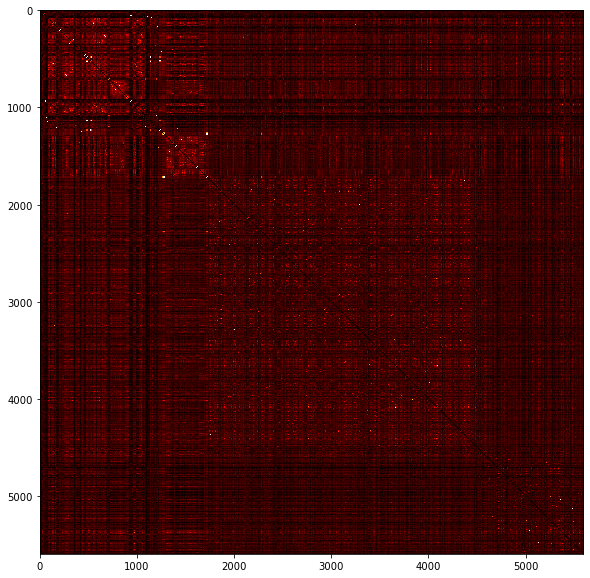

In [107]:
from openeye.oegraphsim import *
from openeye.oechem import *

fptype = OEFPType_Circular #I have no idea if this is best, see https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html#chapter-fingerprint for options

# Make fingerprints for both sets
release_set_fp = []
release_set_mols = []
for smi in release_smi:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    fp = OEFingerPrint()
    OEMakeFP(fp, mol, fptype)
    release_set_fp.append(fp)
    release_set_mols.append(mol)
    
ds_set_fp = []
ds_set_mols = []
for smi in ds_smiles:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    fp = OEFingerPrint()
    OEMakeFP(fp, mol, fptype)
    ds_set_fp.append(fp)
    ds_set_mols.append(mol)
    
    
# Compute full similarity matrix by this OEGraphSim
# Let's make it an (N+M)*(N+M) matrix so we have all-by-all similarities.
# Make coverage set be first N, remainder next M
import numpy as np

N = len(release_smi)
M = len(ds_smiles)

t_matrix = np.zeros( (N+M,N+M), np.float)

comparison_fps = release_set_fp + ds_set_fp
comparison_mols = release_set_mols + ds_set_mols

for n in range(N+M):
    for m in range(N+M):
        if n != m: #Make diagonal elements be zero for more convenience
            t_matrix[n,m] = OETanimoto( comparison_fps[n], comparison_fps[m])

import matplotlib.pyplot as plt
%matplotlib inline

# Plot part of matrix
plt.figure(figsize =(10,10))
#plt.imshow(t_matrix[0:1000,0:1000], cmap='hot')
plt.imshow(t_matrix, cmap='hot')

## Next cluster to find molecules which are "alone"

In general many of our molecules are not super similar to other molecules, which is fine as long as they are built of fragments which are present in other molecules. However, what we are especially interested in is molecules which contain fragments which are not represented anywhere. To do those, we need some kind of clustering.

I might want some kind of hierarchical clustering, because what I'd like to do is not necessarily group all my molecules into clusters, but instead be able to find which molecules are similar to the least other.

DBSCAN looks interesting as it can find "noise" points which are distant from others, and doesn't take a predefined number of clusters. It also can take a precalculated distance matrix. See https://stackoverflow.com/questions/16246066/clustering-based-on-distance-matrix and https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [123]:
#Make distance matrix run from 1 being far to 0 being close rather than the opposite (Tanimoto)
dis_matrix = np.ones_like(t_matrix)-t_matrix

from sklearn.cluster import DBSCAN
from sklearn import metrics

#data_subset = dis_matrix[0:1000,0:1000]
data_subset = dis_matrix

# eps: Controls maximum distance between two samples to be considered as in neighborhood of the other.
# min_samples: Minimum number of samples (compounds) near a compound for it to be considered a core point
# Metric: precomputed means use precomputed distance matrix

# I probably actually want to allow SIGNIFICANT difference between compounds, so I have empirically experimented
# with eps values to see what results in sensible clusters. 
# A value of 0.7 seems far too high; the clusters get too diverse.
# A value of 0.5 gives pretty homogeneous clusters but too many molecules not in clusters.
# A value of 0.6 is somewhat OK 
# That said, things fall off steeply below 0.6 -- 0.58 results in far fewer usable molecules than 0.6
# I've gone with 0.65 as it still seems to yield tolerable clusters and produces far more possible molecules than 0.6
clustering = DBSCAN(eps=0.65, min_samples = 5, metric="precomputed")

# Fit clustering; do first 100 compounds only for now as a test
db = clustering.fit(data_subset)

# Draw on https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py 
# for useful info
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Total number of points: %d' % len(data_subset))
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 86
Total number of points: 5595
Estimated number of noise points: 2213


In [124]:
# Determine how many compounds are in each cluster.
# Cluster "-1" is the "outliers"/noise points that are not in clusters.

mols_by_cluster = {}
cluster_nrs = set(labels)

for label in cluster_nrs:
    mols_by_cluster[label] = []
    
    for (idx, thislabel) in enumerate(labels):
        if thislabel==label:
            mols_by_cluster[label].append(comparison_mols[idx])
            
    print("%d molecules in cluster %s" % (len(mols_by_cluster[label]), label))

2232 molecules in cluster 0
21 molecules in cluster 1
8 molecules in cluster 2
9 molecules in cluster 3
8 molecules in cluster 4
21 molecules in cluster 5
13 molecules in cluster 6
15 molecules in cluster 7
14 molecules in cluster 8
6 molecules in cluster 9
6 molecules in cluster 10
7 molecules in cluster 11
9 molecules in cluster 12
12 molecules in cluster 13
7 molecules in cluster 14
7 molecules in cluster 15
10 molecules in cluster 16
21 molecules in cluster 17
7 molecules in cluster 18
7 molecules in cluster 19
13 molecules in cluster 20
11 molecules in cluster 21
16 molecules in cluster 22
6 molecules in cluster 23
12 molecules in cluster 24
7 molecules in cluster 25
33 molecules in cluster 26
10 molecules in cluster 27
7 molecules in cluster 28
6 molecules in cluster 29
9 molecules in cluster 30
23 molecules in cluster 31
7 molecules in cluster 32
6 molecules in cluster 33
31 molecules in cluster 34
12 molecules in cluster 35
7 molecules in cluster 36
10 molecules in cluster 37
2

In [125]:
# Generate PDF files visualizing the contents of all clusters except -1

from openeye import oedepict
import shutil
import os
if os.path.isdir('cluster_pdfs'): shutil.rmtree('cluster_pdfs')
os.mkdir('cluster_pdfs')

for label in mols_by_cluster:
    if label=='-1':
        continue
        
    oemols = [ OEMol(mol) for mol in mols_by_cluster[label]]
    itf = oechem.OEInterface()
    PageByPage = True
    suppress_h = True
    rows = 10
    cols = 6
    ropts = oedepict.OEReportOptions(rows, cols)
    ropts.SetHeaderHeight(25)
    ropts.SetFooterHeight(25)
    ropts.SetCellGap(2)
    ropts.SetPageMargins(10)
    report = oedepict.OEReport(ropts)
    cellwidth, cellheight = report.GetCellWidth(), report.GetCellHeight()
    opts = oedepict.OE2DMolDisplayOptions(cellwidth, cellheight, oedepict.OEScale_Default * 0.5)
    opts.SetAromaticStyle(oedepict.OEAromaticStyle_Circle)
    pen = oedepict.OEPen(oechem.OEBlack, oechem.OEBlack, oedepict.OEFill_On, 1.0)
    opts.SetDefaultBondPen(pen)
    oedepict.OESetup2DMolDisplayOptions(opts, itf)
    for i, mol in enumerate(oemols):
        cell = report.NewCell()
        mol_copy = oechem.OEMol(mol)
        oedepict.OEPrepareDepiction(mol_copy, False, suppress_h)
        disp = oedepict.OE2DMolDisplay(mol_copy, opts)

        oedepict.OERenderMolecule(cell, disp)

    oedepict.OEWriteReport("cluster_pdfs/cluster%s.pdf" % label, report) 

In [126]:
# Figure out which of our clusters don't contain any training set molecules (and which!)

clusters_with_training_mols = []
test_smi = []
for label in cluster_nrs:
    # Get isomeric SMILES strings for molecules in cluster
    cluster_smis = [ OECreateIsoSmiString(mol) for mol in mols_by_cluster[label]]
    
    # Check if these are in training set molecules
    has_training = False
    for smi in cluster_smis:
        if smi in release_smi:
            has_training = True
            tr_smi = smi
            break
    if has_training:
        print("Cluster %s contains training set molecule %s" % (label, tr_smi) )
        clusters_with_training_mols.append(label)
        for smi in cluster_smis:
            if smi not in release_smi and label != -1:
                test_smi.append(smi)
    else:
        print("No training set molecule found for cluster %s." % label)
clusters_with_training_mols.remove(-1) #Remove "outliers" cluster
        
mols_in_tr_set_clusters = 0
for label in clusters_with_training_mols:
    mols_in_tr_set_clusters += len(mols_by_cluster[label])
print("%s molecules in training set clusters" % mols_in_tr_set_clusters)
print("Number of possible test set molecules %s" % len(test_smi))

Cluster 0 contains training set molecule C#Cc1ccccc1
Cluster 1 contains training set molecule C(CBr)c1[nH]nnn1
Cluster 2 contains training set molecule C(CO)O
Cluster 3 contains training set molecule C1CC1NC(=O)C[N@@H+]2C[C@@H](CO2)O
Cluster 4 contains training set molecule C1CC1NC(=O)C[N@@]2C[C@@H](CO2)O
Cluster 5 contains training set molecule C1CS(=O)(=O)CCC12CN=C(O2)N
Cluster 6 contains training set molecule C1NC[C@@H]2[C@@H]1[C@H]2O
Cluster 7 contains training set molecule C1[C@@H](O1)CCCF
Cluster 8 contains training set molecule CC(=C)C1(CC1)CON
Cluster 9 contains training set molecule CC(=O)N[P@@](=O)(OC)SC
Cluster 10 contains training set molecule CC(C)n1ccccc1=O
Cluster 11 contains training set molecule CC/C=C/C
Cluster 12 contains training set molecule CC1([C@@H]2[C@@H]1CCC2)O
Cluster 13 contains training set molecule CC1=NCC(=O)Nc2c1cccc2
Cluster 14 contains training set molecule CCCN1CCCC1=O
Cluster 15 contains training set molecule CCOP(=O)(N)OCC
Cluster 16 contains traini

## Narrow down the test set molecules

Currently we have a draft set of test set molecules which is manageable/relatively small. However, we haven't checked whether these use any of our rare parameters. Now it's time to compute which parameters they use, and see how many of these are using rare parameters not well represented in our training set. Such molecules may not be good parts of our core test set.

In [122]:
#Figure out parameter usage in potential test set molecules.

# Initialize storage
ts_parameters_by_ID = dict()

# Let's label using our RC force field
forcefield = ForceField('openff_unconstrained-1.0.0-RC1.offxml')

# Loop over smiles
for smi in test_smi:

    # Create a simple molecule from SMILES and turn it into a topology.
    molecule = Molecule.from_smiles(smi)
    topology = Topology.from_molecules([molecule])

    # Run the molecule labeling
    molecule_force_list = forcefield.label_molecules(topology)

    #print(smi)
    # Print out a formatted description of the parameters applied to this molecule
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        for force_tag, force_dict in mol_forces.items():
            for (atom_indices, parameter) in force_dict.items():
                pid = parameter.id
                if not pid in ts_parameters_by_ID:
                    ts_parameters_by_ID[pid] = set()
                ts_parameters_by_ID[pid].add(smi)


In [127]:
# Cross check against our rare parameters list and see which of these use rare parameters

eliminated_mols = set()
elimination_reasons = dict()
for pid in ts_parameters_by_ID:
    if pid in rare_params:
        for smi in ts_parameters_by_ID[pid]:
            eliminated_mols.add(smi)
            #print("Ruled out %s because it utilizes rare parameter %s..." % (smi,pid))
            if not pid in elimination_reasons:
                elimination_reasons[pid] = 0
            elimination_reasons[pid] += 1
            
print("Eliminated %s molecules..." % len(eliminated_mols))
print("Molecules were eliminated because of these parameters:")
print("   parameter ID \t number of times ")
for pid in elimination_reasons:
    print('   %10s \t\t\t %s' % (pid, elimination_reasons[pid]))
#print(elimination_reasons)

# What ARE those parameters which are particularly troubling?

#Try removing these from test set and see what's left
new_test_set = []
for smi in test_smi:
    if not smi in eliminated_mols:
        new_test_set.append(smi)
        
print("%s molecules would remain." % len(new_test_set))

Eliminated 426 molecules...
Molecules were eliminated because of these parameters:
   parameter ID 	 number of times 
          b71 			 273
          b23 			 54
          b73 			 37
          t34 			 5
          b30 			 2
          b24 			 31
          a37 			 19
          t89 			 11
          t37 			 1
          t32 			 6
         t127 			 2
           t6 			 3
           n5 			 3
          b27 			 12
          b85 			 12
          n10 			 12
         t125 			 5
          t63 			 3
          t28 			 2
          b45 			 1
          b43 			 1
         t149 			 1
         t114 			 9
         t115 			 3
          t38 			 1
713 molecules would remain.


In [129]:
parameters = forcefield.get_parameter_handler('Bonds').parameters + forcefield.get_parameter_handler('Angles').parameters+forcefield.get_parameter_handler('ProperTorsions').parameters
for parameter in parameters:
    if parameter.id in elimination_reasons:
        print(parameter.id, parameter.smirks, elimination_reasons[parameter.id])

b23 [#6X2:1]-[#6:2] 54
b24 [#6X2:1]-[#6X4:2] 31
b27 [#6X2:1]#[#6X2:2] 12
b30 [#6X2:1]=[#7:2] 2
b43 [#16:1]-[#16:2] 1
b45 [#16:1]-[#17:2] 1
b71 [#6:1]-[#35:2] 273
b73 [#6:1]-[#53:2] 37
b85 [#6X2:1]-[#1:2] 12
a37 [#6X3:1]-[#16X2:2]-[#1:3] 19
t6 [#9:1]-[#6X4:2]-[#6X4:3]-[#9:4] 3
t28 [#6X4:1]-[#6X4;r3:2]-[#6X3:3]~[#6X3:4] 2
t32 [#6X3:1]-[#6X4;r3:2]-[#6X3:3]~[#6X3:4] 6
t34 [#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3:3]~[#6X3:4] 5
t37 [#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3;r5:3]=;@[#6X3;r5:4] 1
t38 [#6X4;r3:1]-;@[#6X4;r3:2]-[#6X3:3]-[#6X4:4] 1
t63 [#8X2H0:1]-[#6X4:2]-[#7X3:3]-[#6X3:4] 3
t89 [#6X4:1]-[#8X2:2]-[#6X4:3]-[#8X2:4] 11
t114 [*:1]~[#15:2]-[#6:3]-[*:4] 9
t115 [*:1]~[#15:2]-[#6X3:3]~[*:4] 3
t125 [*:1]-[#7X4,#7X3:2]-[#7X3$(*~[#6X3,#6X2]):3]~[*:4] 5
t127 [*:1]-[#7X3$(*-[#6X3,#6X2])r5:2]-@[#7X3$(*-[#6X3,#6X2])r5:3]~[*:4] 2
t149 [*:1]-[#16X2,#16X3+1:2]-[#16X2,#16X3+1:3]-[*:4] 1


## Next: Build test/benchmark sets, and stretch versions thereof

Random partition remaining molecules into test/benchmark sets. Then take those molecules which are NOT still remaining as candidates for the test set and partition into stretch test/benchmark sets


# Bonus stuff we're not currently using

### Some sample depiction of a molecule pair

In [ ]:
from openeye.oedepict import *
from openeye.oegrapheme import *
from openeye.oegraphsim import *

# Pull example from 
# https://docs.eyesopen.com/toolkits/cookbook/python/depiction/fpoverlap.html
def SetFingerPrintSimilarity(qmol, tmol, fptype, tag, maxvalue=0):

    qbonds = OEUIntArray(qmol.GetMaxBondIdx())
    tbonds = OEUIntArray(tmol.GetMaxBondIdx())

    for match in OEGetFPOverlap(qmol, tmol, fptype):
        for bond in match.GetPatternBonds():
            qbonds[bond.GetIdx()] += 1
        for bond in match.GetTargetBonds():
            tbonds[bond.GetIdx()] += 1

    maxvalue = max(maxvalue, max(qbonds))
    maxvalue = max(maxvalue, max(tbonds))

    for bond in qmol.GetBonds():
        bond.SetData(tag, qbonds[bond.GetIdx()])
    for bond in tmol.GetBonds():
        bond.SetData(tag, tbonds[bond.GetIdx()])

    return maxvalue

class ColorBondByOverlapScore(OEBondGlyphBase):
    def __init__(self, cg, tag):
        OEBondGlyphBase.__init__(self)
        self.colorg = cg
        self.tag = tag

    def RenderGlyph(self, disp, bond):

        bdisp = disp.GetBondDisplay(bond)
        if bdisp is None or not bdisp.IsVisible():
            return False

        if not bond.HasData(self.tag):
            return False

        linewidth = disp.GetScale() / 3.0
        color = self.colorg.GetColorAt(bond.GetData(self.tag))
        pen = OEPen(color, color, OEFill_Off, linewidth)

        adispB = disp.GetAtomDisplay(bond.GetBgn())
        adispE = disp.GetAtomDisplay(bond.GetEnd())

        layer = disp.GetLayer(OELayerPosition_Below)
        layer.DrawLine(adispB.GetCoords(), adispE.GetCoords(), pen)

        return True

    def ColorBondByOverlapScore(self):
        return ColorBondByOverlapScore(self.colorg, self.tag).__disown__()

def DepictMoleculeOverlaps(image, qmol, tmol, fptype, opts):

    tag = OEGetTag("fpoverlap")
    maxvalue = SetFingerPrintSimilarity(qmol, tmol, fptype, tag)

    colorg = OELinearColorGradient()
    colorg.AddStop(OEColorStop(0.0, OEPinkTint))
    colorg.AddStop(OEColorStop(1.0, OEYellow))
    colorg.AddStop(OEColorStop(maxvalue, OEDarkGreen))
    bondglyph = ColorBondByOverlapScore(colorg, tag)

    OEPrepareDepiction(qmol)
    overlaps = OEGetFPOverlap(qmol, tmol, fptype)
    OEPrepareMultiAlignedDepiction(tmol, qmol, overlaps)

    grid = OEImageGrid(image, 1, 2)
    grid.SetMargin(OEMargin_Bottom, 10)
    opts.SetDimensions(grid.GetCellWidth(), grid.GetCellHeight(), OEScale_AutoScale)
    opts.SetAtomColorStyle(OEAtomColorStyle_WhiteMonochrome)

    molscale = min(OEGetMoleculeScale(qmol, opts), OEGetMoleculeScale(tmol, opts))
    opts.SetScale(molscale)

    qdisp = OE2DMolDisplay(qmol, opts)
    OEAddGlyph(qdisp, bondglyph, IsTrueBond())
    OERenderMolecule(grid.GetCell(1, 1), qdisp)

    tdisp = OE2DMolDisplay(tmol, opts)
    OEAddGlyph(tdisp, bondglyph, IsTrueBond())
    OERenderMolecule(grid.GetCell(1, 2), tdisp)

    qfp = OEFingerPrint()
    OEMakeFP(qfp, qmol, fptype)

    tfp = OEFingerPrint()
    OEMakeFP(tfp, tmol, fptype)

    score = OETanimoto(qfp, tfp)

    font = OEFont(OEFontFamily_Default, OEFontStyle_Default, 16, OEAlignment_Center, OEBlack)
    center = OE2DPoint(image.GetWidth() / 2.0, image.GetHeight() - 10)
    image.DrawText(center, "Tanimoto score = %.3f" % score, font)

In [ ]:
from openeye.oedepict import *
fpt = OEGetFPType(fptype)
height = 400.
width = 2.*height
image = OEImage(width, height)
opts = OE2DMolDisplayOptions(width, height, OEScale_AutoScale)

DepictMoleculeOverlaps(image, coverage_set_mols[4], ds_set_mols[848], fpt, opts)
OEWriteImage("tmp.png", image)



<img src = "tmp.png">